In [6]:
from tqdm import tqdm
import pickle
import numpy as np
import torch
import torch.utils.data as data
import typing as t
import numpy as np
import keras.datasets as datasets
import pathlib as pb
from sklearn.metrics import accuracy_score


seed = 42
root = pb.Path('.')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Task I: Word-based CNN for Text Classification

### 1. Data

The dataset that we are going to use is the imdb dataset of movie reviews. These are labelled by sentiment (positive/negative). 

The reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). 

For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

More information regarding the dataset can be found in the official [documentation](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification).


### 2. Preprocess the text data 

In this particular case, where we are using the imdb dataset there is no need to do all the traditional preprocessings that we normally do when dealing with NLP problems. Part of them are already done at this point.

  - Split the dataset in train and test (maybe also validation).
  - Tokenize and transform to integer index. Here we would need to: 
    - instantitate a *Tokenizer()* object, 
    - fit that object on the text on which we are training the model (use the *fit_on_texts()* method)
    - call *texts_to_sequences()* for both the training and the test text.

  - **Add padding to ensure that all vectors have the same dimensionality.** Note that this is the only pre-processing that needs to be done in the case of the current imdb dataset.

In [7]:
class IMDBDataset(data.Dataset):
    padding_idx: int = 10001

    def __init__(self,
                 index_from: int = 0,
                 num_words: int = 10_000,
                 sample_length: int = 1_000,
                 split: t.Literal['train', 'test'] = 'train'):
        super(IMDBDataset, self).__init__()

        # Load the dataset
        (train_X, train_y), (test_X, test_y) = datasets.imdb.load_data('imdb.npz',
                                                                       num_words=num_words,
                                                                       index_from=index_from)

        # Persist only the specific split
        self.samples = train_X if split == 'train' else test_X
        self.labels = train_y if split == 'train' else test_y
        self.length = sample_length
        self.padding_idx = IMDBDataset.padding_idx

    def __getitem__(self, index) -> t.Tuple[torch.Tensor, torch.Tensor]:
        sample = self.samples[index]
        label = self.labels[index]

        # Perform trimming
        if len(sample) > self.length:
            sample = sample[:self.length]

        # Transform to tensor
        sample = torch.tensor(sample)
        label = torch.tensor(label)

        # Perform padding
        sample = torch.nn.functional.pad(
            sample, (0, self.length - len(sample)), value=self.padding_idx)
        return sample, label

    def __len__(self) -> int:
        return len(self.samples)


# Customize generator
gen = torch.Generator(device='cpu')
gen.manual_seed(seed)

# Train & Test datasets
train_data = IMDBDataset(split='train')
test_data = IMDBDataset(split='test')

# Create validation subset with generator
train_data, valid_data = data.random_split(train_data, [0.9, 0.1], gen)

### 3.  Define the model de dataset and the training loop

Similar to the privious lab while following the model architecture described in the comments.

In [8]:
import torch.nn as nn


class ConvLayer(torch.nn.Module):
    def __init__(self,
                 input_channels: int,
                 output_channels: int,
                 kernel_size: int,
                 padding: int,
                 pooling_size: int=2):
        super(ConvLayer, self).__init__()

        # Create layers
        self.conv = nn.Conv1d(in_channels=input_channels,
                              out_channels=output_channels,
                              kernel_size=kernel_size,
                              padding=padding)
        self.bn = nn.BatchNorm1d(num_features=output_channels)
        self.activ_fn = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=pooling_size, stride=2)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x: torch.Tensor = self.conv(input)
        x = self.bn(x)
        x = self.activ_fn(x)
        x = self.pool(x)
        return x


class TextCNN(torch.nn.Module):
    def __init__(self, padding_idx: int = IMDBDataset.padding_idx):
        super(TextCNN, self).__init__()

        # Model Configuration
        self.num_embeddings = 10_002
        self.embedding_dim = 100

        # Define an embedding layer with a vocabulary size of 10002
        # an output embedding size of 100
        # and a padding_idx equal to the one used - 10001
        self.embedding = nn.Embedding(num_embeddings=self.num_embeddings,
                                      embedding_dim=self.embedding_dim,
                                      padding_idx=padding_idx)

        # Define the following sequence of layers
        # A dropout layer with a probability of 0.4
        self.drop1 = nn.Dropout(p=0.4)

        # A 1D Convolutional layer with 100 input channels, 128 output channels, kernel size of 3 and a padding of 1
        # A 1D Batch Normalization Layer for 128 features
        # A ReLU activation
        # A 1D Maxpooling layer with size 2
        self.conv_layer1 = ConvLayer(100, 128, 3, 1)

        # A 1D Convolutional layer with 128 input channels, 128 output channels, kernel size of 5 and a padding of 2
        # A 1D Batch Normalization Layer for 128 features
        # A ReLU activation
        # A 1D Maxpooling layer with size 2
        self.conv_layer2 = ConvLayer(128, 128, 5, 2)

        # A 1D Convolutional layer with 128 input channels, 128 output channels, kernel size of 5 and a padding of 2
        # A 1D Batch Normalization Layer for 128 features
        # A ReLU activation
        # A 1D Maxpooling layer with size 2
        self.conv_layer3 = ConvLayer(128, 128, 5, 2)

        # A global Average pooling layer, which in this scenario, will be an 1D Avgerage Pooling layer
        # with size 125 and stride 125
        self.pool = nn.AvgPool1d(125, 125)

        # A Flattening layer
        self.flatten = nn.Flatten()

        # A Linear layer with 128 input features and 2 outputs and no activation function
        self.dense = nn.Linear(in_features=128, out_features=2)

    def forward(self, input):
        # forward the input through the embedding layer
        x: torch.Tensor = self.embedding(input)

        # permute the input such that it becomes channels first
        x = x.permute((0, 2, 1))

        # forward the input through the rest of the sequence of layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [9]:
# instantiate the model
model = TextCNN()

# define an Adam optimizer for the model with a lr of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# define a Cross Entropy loss function
loss_fn = nn.CrossEntropyLoss()

# customize training loop
batch_size = 16
epochs = 10

# define the training dataloader and the test dataloader
train_loader = data.DataLoader(train_data,
                               batch_size=batch_size,
                               shuffle=True,
                               generator=gen)
valid_loader = data.DataLoader(valid_data,
                               batch_size=batch_size,
                               shuffle=True,
                               generator=gen)
test_loader = data.DataLoader(test_data,
                              batch_size=batch_size,
                              shuffle=True,
                              generator=gen)

# Send model to GPU
model.to(device)

TextCNN(
  (embedding): Embedding(10002, 100, padding_idx=10001)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv_layer1): ConvLayer(
    (conv): Conv1d(100, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ_fn): ReLU()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): ConvLayer(
    (conv): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ_fn): ReLU()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): ConvLayer(
    (conv): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ_fn): ReLU()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilati

In [10]:
# keep track of the training progress
history = {
    'acc': [],
    'loss': [],
    'val_acc': [],
    'val_loss': [],
}

# write the training loop as defined in Lab 1 and train the model
for e in range(epochs):
    ### TRAINING ###
    loss = torch.tensor(0)
    labels = torch.empty((2, len(train_data)))

    model.train()
    model.requires_grad_(True)
    for b, (X, y) in enumerate(train_loader):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.to(device)

        optimizer.zero_grad()
        logits: torch.Tensor = model(X)
        loss: torch.Tensor = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        y_hat: torch.Tensor = torch.argmax(logits, dim=-1)
        labels[0][b * batch_size:(b + 1) * batch_size] = y_hat.detach().cpu()
        labels[1][b * batch_size:(b + 1) * batch_size] = y.cpu()
    train_loss = loss.item()
    train_score = accuracy_score(labels[1], labels[0])

    ### VALIDATION ###
    loss = torch.tensor(0)
    labels = torch.empty((2, len(valid_data)))

    model.eval()
    model.requires_grad_(False)
    for b, (X, y) in enumerate(valid_loader):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.to(device)

        logits: torch.Tensor = model(X)
        loss: torch.Tensor = loss_fn(logits, y)

        y_hat: torch.Tensor = torch.argmax(logits, dim=-1)
        labels[0][b * batch_size:(b + 1) * batch_size] = y_hat.detach().cpu()
        labels[1][b * batch_size:(b + 1) * batch_size] = y.cpu()
    valid_loss = loss.item()
    valid_score = accuracy_score(labels[1], labels[0])

    # Track metrics
    history['loss'].append(train_loss)
    history['acc'].append(train_score)
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_score)
    print('[epoch: %d/%d; train_loss: %f; train_acc: %f, valid_loss: %f; valid_acc: %f]'
          % (e + 1, epochs, train_loss, train_score, valid_loss, valid_score))

KeyboardInterrupt: 

In [11]:
def evaluate(model: nn.Module, data_loader: data.DataLoader):
    model.eval()
    model.requires_grad_(False)
    labels = torch.empty((2, len(t.cast(t.Sized, data_loader.dataset))))
    for b, (X, y) in enumerate(data_loader):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.to(device)

        logits: torch.Tensor = model(X)
        y_hat: torch.Tensor = torch.argmax(logits, dim=-1)

        batch_start = b * t.cast(int, data_loader.batch_size)
        batch_stop = (b + 1) * t.cast(int, data_loader.batch_size)

        labels[0][batch_start:batch_stop] = y_hat.detach().cpu()
        labels[1][batch_start:batch_stop] = y.cpu()
    score = accuracy_score(labels[1], labels[0])
    return score

In [12]:
train_score = evaluate(model, train_loader)
print("Train Accuracy: {:.4f}".format(train_score))

valid_score = evaluate(model, valid_loader)
print("Valid Accuracy: {:.4f}".format(valid_score))

test_score = evaluate(model, test_loader)
print("Test Accuracy: {:.4f}".format(test_score))


Train Accuracy: 0.8625
Valid Accuracy: 0.8428
Test Accuracy: 0.8402


In [13]:
(root / '.weights').mkdir(exist_ok=True)
torch.save(model.state_dict(), '.weights/imdb.pt')

In [14]:
model = TextCNN().to(device)
model.load_state_dict(torch.load('.weights/imdb.pt'))

<All keys matched successfully>

In [15]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_history(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

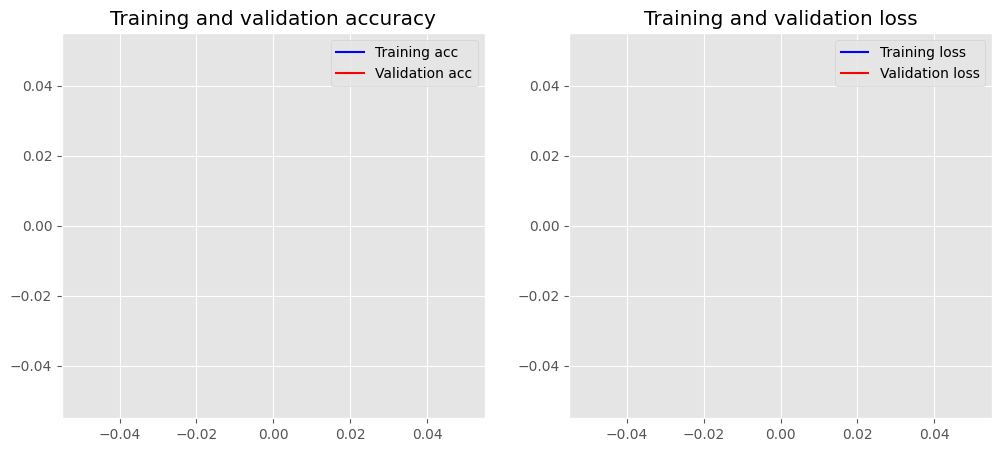

In [16]:
%matplotlib inline
plot_history(history)

## Task II: Character-based CNN for Text Classification

Time permitting, implement the character-based version of the CNN which is able to classify the movie reviews by sentiment.

You can have a look at the few implementations that can be found online. For example, this implementation is really similar with what has been implemented in the first paper where the problem of character-based CNN is formally tackled: https://github.com/chaitjo/character-level-cnn/blob/master/models/char_cnn_kim.py. 

However, keep in mind that for this particular dataset there are some modifications that need to be done. Your challenge is to discover those.

### 1. Restore the strings in the dataset
In this class, we have decided to use the imdb dataset from keras datasets. The only problem with this when trying to implement a character-based NN is that it has already performed the word2vec changes. This optimization, as we have seen in the Task I, is a really helpful one when implementing a word-based CNN. However this is not the case for a character based CNN, as we need to extract some information from the text, in order to be able to build the model.

> **1.1.** **Map IDs to words**
- **1.1.1.** Get the indexes corresponding to each word as per the imdb dataset (and module in keras). Hint: look up get_word_index().
- **1.1.2.** Shift with 3 the values in the word_to_id dictionary populated above. In other words, for key k, the value is going to be v + 3 instead of v now. We do this because the first 3 indexes are reserved for special symbols (see at the next step).
- **1.1.3.** Indexes 0-3 are now taken by the following special characters: "\<PAD>", "\<START>", "\<UNK>", "\<UNUSED>". Mark this by assigning the appropriate values to those keys.
- **1.1.4.** Reverse the roles in word_to_id. Build an id_to_word dictionary with the same content, and the difference that here the keys are the values from word_to_id and the values are the keys from that dictionary. We are doing this in order to ease the (re)conversion to text. 

> **1.2.** **Restore the text data**
- **1.2.1.** Get the corresponding words for the ids in the dataset. Use the function implemented following the steps above.
- **1.2.2.** For each sample (list of indexes corresponding to words in that review) in the dataset, perform the conversion to string, appending the words found at those indexes. Hint: use join() maybe and list comprehension.

> **1.3.** **Load the dataset** with only the top 5000 words.

> **1.4.** Restore both the training and test text


In [17]:
def map_ids_to_words():
    """
    1.1. Map ids to words

    This method returns a dictionary representing a mapping id -> word like 
    it is in the imdb dataset from keras datasets.

    """
    # 1.1.1. Get word indexes from the imdb dataset
    word_to_id: t.Dict[str, int] = datasets.imdb.get_word_index()

    # 1.1.2. Shift with 3 (value + 3) the indexes in word_to_id
    word_to_id = {k: (v+3) for k, v in word_to_id.items()}

    # 1.1.3. Indexes 0-3 are now taken by the following special characters: "<PAD>", "<START>", "<UNK>", "<UNUSED>".
    tokens: t.List[str] = ['<PAD>', '<START>', '<UNK>', '<UNUSED>']
    word_to_id.update({tkn: i for i, tkn in enumerate(tokens)})

    # 1.1.4. Reverse the roles in word_to_id (now the values become keys)
    id_to_word = {value: key for key, value in word_to_id.items()}
    return id_to_word


def restore_text_data(dataset):
    """
    1.2. Restore the text data.

    Use the method declared above to mapt the ids in the imdb representation to actual words.
    """
    str_data = []

    # 1.2.1. Get the corresponding words for the ids in the dataset.
    id_to_word = map_ids_to_words()

    # 1.2.2. For each sample in the dataset, perform the conversion to string
    for i in range(len(dataset)):
        str_data.append(' '.join(id_to_word[id] for id in dataset[i]))

    return str_data


# 1.3. Load the dataset
(x_train, y_train), (x_test, y_test) = datasets.imdb.load_data(num_words=5_000, index_from=3)

# 1.4. Restore text data for both training and test
X_train_str = restore_text_data(x_train)
X_test_str = restore_text_data(x_test)
X_train_str[:10]

["<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what th

### 2. Get the vocabulary
> **2.1.** Get the vocabulary - identify the set of characters ("vocabulary") for this dataset.

### 3. Create a Tokenizer

> **3.1.** Initialize the tokenizer. The important parameters here are:
- **char_level**=True: this can tell tk.texts_to_sequences() to process sentence in char level.
- **oov_token**='UNK': this will add a UNK token in the vocabulary. We can call it by tk.oov_token.
- **num_words**=None for starters.

> **3.2.** After calling tk.fit_on_texts(X_train_str), the tk object will contain the neccery information about the training data. 

> **3.3.** Build a character dictionary based on our alphabet (chars). 


In [18]:
from collections import OrderedDict


class Tokenizer(object):
    def __init__(self,
                 oov: str = 'UNK',
                 pad: str = 'PAD',
                 num_words=None,
                 lower: bool = True,
                 split: str = ' ',
                 filters: t.Optional[str] = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') -> None:
        super(Tokenizer, self).__init__()
        self.oov = oov
        self.pad = pad
        self.split = split
        self.lower = lower
        self.num_words = num_words
        self.filter_table = str.maketrans(
            {c: split for c in filters}) if filters else None

    def fit(self, txts) -> None:
        txts = [self.__preproc(txt) for txt in txts]
        self.vocab = set(''.join(txts))
        self.char2id: t.Dict[str, int] = OrderedDict([(self.pad, 0), (self.oov, 1)])
        self.char2id.update([(x, i + 2) for i, x in enumerate(self.vocab)])
        self.vocab.update({self.pad, self.oov})
        self.id2char: t.Dict[int, str] = {
            v: k for k, v in self.char2id.items()}

    def txt2seq(self, txt):
        if isinstance(txt, str):
            return self.__txt2seq(txt)
        else:
            return [self.__txt2seq(t) for t in txt]

    def seq2txt(self, seq):
        if isinstance(seq, list) and len(seq) == 0:
            return ''
        elif isinstance(seq, list) and not isinstance(seq[0], list):
            return self.__seq2txt(seq)
        else:
            return [self.__seq2txt(t) for t in seq]

    def __txt2seq(self, txt):
        v: t.List[int] = []
        txt = self.__preproc(txt)
        for c in txt:
            if (i := self.char2id.get(c)) is None:
                v.append(self.char2id[self.oov])
            elif self.num_words and i >= self.num_words:
                v.append(self.char2id[self.oov])
            else:
                v.append(i)
        return v

    def __seq2txt(self, seq):
        return ''.join([self.id2char[i] for i in seq])

    def __preproc(self, txt):
        if self.lower:
            txt = txt.lower()
        if self.filter_table:
            txt = txt.translate(self.filter_table)
        return txt


tkn = Tokenizer(filters=None, lower=False)
tkn.fit(X_train_str)
tkn.char2id

OrderedDict([('PAD', 0),
             ('UNK', 1),
             ('7', 2),
             ('N', 3),
             ('p', 4),
             ('c', 5),
             ('0', 6),
             ('1', 7),
             ('T', 8),
             ('é', 9),
             ('S', 10),
             ('z', 11),
             ('j', 12),
             ('m', 13),
             ('l', 14),
             ('<', 15),
             ('K', 16),
             ('2', 17),
             (' ', 18),
             ('o', 19),
             ('A', 20),
             ('\x96', 21),
             ('v', 22),
             ('U', 23),
             ('b', 24),
             ('s', 25),
             ('q', 26),
             ('5', 27),
             ('6', 28),
             ('n', 29),
             ('k', 30),
             ('h', 31),
             ('d', 32),
             ('e', 33),
             ('8', 34),
             ('r', 35),
             ('u', 36),
             ('t', 37),
             ('g', 38),
             ('3', 39),
             ('i', 40),
             ('f', 

### 4. Yet another few preprocessings before building the actual model

> **4.1.** Conversions to be done for both the test/training text.
- **4.1.1.** Convert the strings in the text datasets to arrays of indexes. Hint: use texts_to_sequences().
- **4.1.2.** The sequences need to have the same length, so pad_sequences() until the maxlen of 1024.
- **4.1.3.** Convert to numpy array.

> **4.2.** One-hot encode the set of targets for the training.

> **4.3.** One-hot encode the set of targets for the test. Hint: to_categorical().

In [19]:
def preprocess_dataset(dataset: t.List[str], tk: Tokenizer, maxlen: int=1024):
    """
    4.1. Conversions to be done for both the test/training text.
    """
    # 4.1.1. Convert string to index
    sequences: t.List[t.List[int]] = [t.cast(t.List[int], tkn.txt2seq(doc)) for doc in dataset]

    # 4.1.2. Padding
    proc_data = [(s + [0,] * (max(0, maxlen - len(s))))[:maxlen] for s in sequences]

    # 4.1.3. Convert to numpy array
    proc_data = np.array(proc_data)
    return proc_data


# Preprocess once
train_data = preprocess_dataset(X_train_str, tkn)
test_data = preprocess_dataset(X_test_str, tkn)

# Transform to PyTorch format
train_data = data.TensorDataset(torch.tensor(train_data), torch.tensor(y_train))
test_data = data.TensorDataset(torch.tensor(test_data), torch.tensor(y_test))

# Split train to have validation subset
train_data, valid_data = data.random_split(train_data, [0.9, 0.1], gen)

# See current vocabulary
vocab_size = len(tkn.vocab)
print("vocabulary: ", tkn.char2id)
print("vocabulary size: ", vocab_size)

vocabulary:  OrderedDict([('PAD', 0), ('UNK', 1), ('7', 2), ('N', 3), ('p', 4), ('c', 5), ('0', 6), ('1', 7), ('T', 8), ('é', 9), ('S', 10), ('z', 11), ('j', 12), ('m', 13), ('l', 14), ('<', 15), ('K', 16), ('2', 17), (' ', 18), ('o', 19), ('A', 20), ('\x96', 21), ('v', 22), ('U', 23), ('b', 24), ('s', 25), ('q', 26), ('5', 27), ('6', 28), ('n', 29), ('k', 30), ('h', 31), ('d', 32), ('e', 33), ('8', 34), ('r', 35), ('u', 36), ('t', 37), ('g', 38), ('3', 39), ('i', 40), ('f', 41), ('w', 42), ('x', 43), ('>', 44), ('4', 45), ('y', 46), ('R', 47), ('9', 48), ("'", 49), ('a', 50)])
vocabulary size:  51


### 6. Build the model

> **6.1.** Instatiate the sequential model with no layers.

> **6.2.** Add an Embedding layer with vocab_size + 1, embedding_size, input_size as input_length and embedding_weights as weights.

> **6.3.** Add the convolutional layers having the \[filter_num, filter_size, pooling_size] specified in conv_layers. Note that if the pooling_size is -1, there is no pooling layer after that CONV. The activation function used is relu.

> **6.4.** Add a Flatten layer.

> **6.5.** Add one Fully connected layer with relu as activation and 1024 hidden units.

> **6.6.** Dropout half of the neurons.

> **6.7.** The output layer uses sigmoid as activation function and has 2 nodes.

> **6.8.** Compile the model with loss, optimizer and accuracy as metric.


In [40]:
class CharCNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(CharCNN, self).__init__(*args, **kwargs)

        # Create OneHot Embeddings to represent the characters
        one_hot_embeddings = torch.vstack([torch.zeros(50), torch.eye((50))])
        self.embeddings = nn.Embedding.from_pretrained(one_hot_embeddings, freeze=True, padding_idx=0)

        # Create ConvLayers
        self.conv_layer1 = ConvLayer(self.embeddings.weight.shape[1], 128, 7, 3)
        self.conv_layer2 = ConvLayer(128, 128, 5, 2)
        self.conv_layer3 = ConvLayer(128, 128, 3, 1)
        self.conv_layer4 = ConvLayer(128, 128, 3, 1)

        # Create Fully-Connected Layers
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(8192, 512)
        self.activ_fn = nn.ReLU()
        self.drop = nn.Dropout1d(p=0.5)

        self.dense2 = nn.Linear(512, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embeddings(x)
        x = x.permute((0, 2, 1))
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.flatten(x)
        x = self.activ_fn(self.dense1(x))
        x = self.drop(x)
        x = self.dense2(x)
        return x.squeeze(1)

In [55]:
# instantiate the model
model = CharCNN()

# define an Adam optimizer for the model with a lr of 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# define a Cross Entropy loss function
loss_fn = nn.BCEWithLogitsLoss()

# customize training loop
batch_size = 8
epochs = 10

# define the training dataloader and the test dataloader
train_loader = data.DataLoader(t.cast(data.Dataset, train_data),
                               batch_size=batch_size,
                               shuffle=True,
                               generator=gen)
valid_loader = data.DataLoader(t.cast(data.Dataset, valid_data),
                               batch_size=batch_size,
                               shuffle=True,
                               generator=gen)
test_loader = data.DataLoader(t.cast(data.Dataset, test_data),
                              batch_size=batch_size,
                              shuffle=True,
                              generator=gen)

# Send model to GPU
model.to(device)

CharCNN(
  (embeddings): Embedding(51, 50, padding_idx=0)
  (conv_layer1): ConvLayer(
    (conv): Conv1d(50, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ_fn): ReLU()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): ConvLayer(
    (conv): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ_fn): ReLU()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): ConvLayer(
    (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ_fn): ReLU()
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer4): ConvL

In [56]:
# keep track of the training progress
history = {
    'acc': [],
    'loss': [],
    'val_acc': [],
    'val_loss': [],
}

# write the training loop as defined in Lab 1 and train the model
for e in range(epochs):
    ### TRAINING ###
    train_loss = 0
    loss = torch.tensor(0)
    labels = torch.empty((2, len(train_data)))

    model.train()
    model.requires_grad_(True)
    for b, (X, y) in enumerate(train_loader):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.float().to(device)

        optimizer.zero_grad()
        logits: torch.Tensor = model(X)
        loss: torch.Tensor = loss_fn(logits, y)
        train_loss += loss.detach().item()
        loss.backward()
        optimizer.step()

        y_hat: torch.Tensor = torch.nn.functional.sigmoid(logits).round()
        labels[0][b * batch_size:(b + 1) * batch_size] = y_hat.detach().cpu()
        labels[1][b * batch_size:(b + 1) * batch_size] = y.cpu()
    train_score = accuracy_score(labels[1], labels[0])
    train_loss /= len(train_loader)

    ### VALIDATION ###
    loss = torch.tensor(0)
    valid_loss = 0
    labels = torch.empty((2, len(valid_data)))

    model.eval()
    model.requires_grad_(False)
    for b, (X, y) in enumerate(valid_loader):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.float().to(device)

        logits: torch.Tensor = model(X)
        loss: torch.Tensor = loss_fn(logits, y)
        valid_loss += loss.item()

        y_hat: torch.Tensor = torch.nn.functional.sigmoid(logits).round()
        labels[0][b * batch_size:(b + 1) * batch_size] = y_hat.detach().cpu()
        labels[1][b * batch_size:(b + 1) * batch_size] = y.cpu()
    valid_score = accuracy_score(labels[1], labels[0])
    valid_loss /= len(valid_loader)

    # Track metrics
    history['loss'].append(train_loss)
    history['acc'].append(train_score)
    history['val_loss'].append(valid_loss)
    history['val_acc'].append(valid_score)
    print('[epoch: %d/%d; train_loss: %f; train_acc: %f, valid_loss: %f; valid_acc: %f]'
          % (e + 1, epochs, train_loss, train_score, valid_loss, valid_score))

[epoch: 1/10; train_loss: 0.699511; train_acc: 0.538089, valid_loss: 0.598533; valid_acc: 0.712800]
[epoch: 2/10; train_loss: 0.612516; train_acc: 0.619111, valid_loss: 0.511893; valid_acc: 0.771200]
[epoch: 3/10; train_loss: 0.583821; train_acc: 0.638178, valid_loss: 0.480253; valid_acc: 0.775200]
[epoch: 4/10; train_loss: 0.571749; train_acc: 0.640489, valid_loss: 0.460335; valid_acc: 0.808400]
[epoch: 5/10; train_loss: 0.565931; train_acc: 0.640178, valid_loss: 0.434328; valid_acc: 0.829200]
[epoch: 6/10; train_loss: 0.551362; train_acc: 0.652933, valid_loss: 0.434277; valid_acc: 0.831200]
[epoch: 7/10; train_loss: 0.537797; train_acc: 0.665911, valid_loss: 0.449350; valid_acc: 0.814800]
[epoch: 8/10; train_loss: 0.522661; train_acc: 0.672267, valid_loss: 0.432946; valid_acc: 0.835600]
[epoch: 9/10; train_loss: 0.515709; train_acc: 0.673867, valid_loss: 0.409874; valid_acc: 0.808000]
[epoch: 10/10; train_loss: 0.505430; train_acc: 0.680311, valid_loss: 0.409856; valid_acc: 0.826800]

In [57]:
(root / '.weights').mkdir(exist_ok=True)
torch.save(model.state_dict(), '.weights/imdb2.pt')

In [58]:
model = CharCNN().to(device)
model.load_state_dict(torch.load('.weights/imdb2.pt'))

<All keys matched successfully>

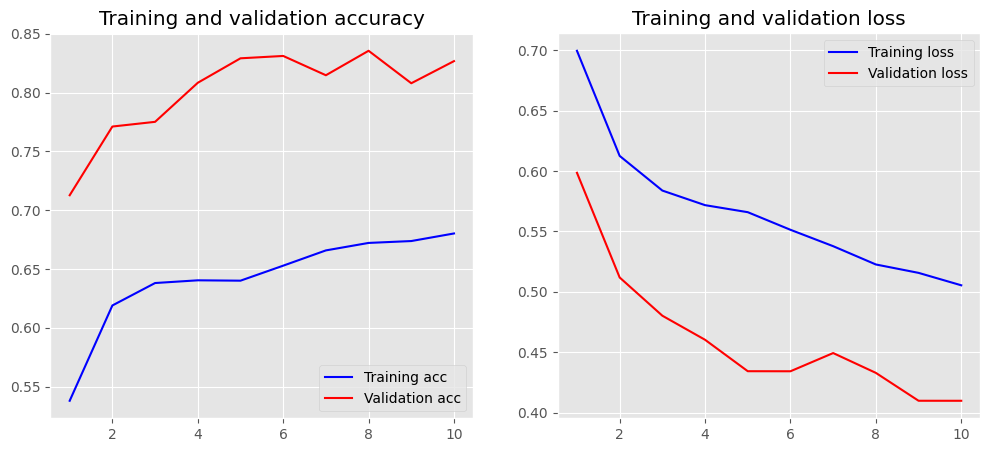

In [59]:
%matplotlib inline
plot_history(history)

In [60]:
def evaluate(model: nn.Module, data_loader: data.DataLoader):
    model.eval()
    model.requires_grad_(False)
    labels = torch.empty((2, len(t.cast(t.Sized, data_loader.dataset))))
    for b, (X, y) in enumerate(data_loader):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.float().to(device)

        logits: torch.Tensor = model(X)
        y_hat: torch.Tensor = torch.nn.functional.sigmoid(logits).round()
        labels[0][b * batch_size:(b + 1) * batch_size] = y_hat.detach().cpu()
        labels[1][b * batch_size:(b + 1) * batch_size] = y.cpu()
    score = accuracy_score(labels[1], labels[0])
    return score

In [61]:
train_score = evaluate(model, train_loader)
print("Train Accuracy: {:.4f}".format(train_score))

valid_score = evaluate(model, valid_loader)
print("Valid Accuracy: {:.4f}".format(valid_score))

test_score = evaluate(model, test_loader)
print("Test Accuracy: {:.4f}".format(test_score))

Train Accuracy: 0.8989
Valid Accuracy: 0.8268
Test Accuracy: 0.8338
